Device: cuda
GPU: Tesla T4
No file at /content/noisy.png - creating noisy astronaut fallback


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

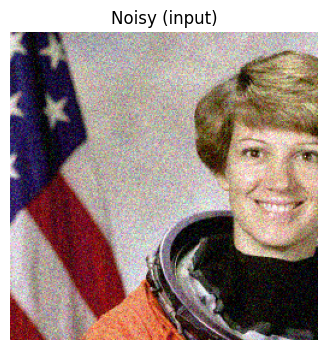

In [ ]:
# Cell 1: Setup, GPU check, load image (or create noisy astronaut if not found)
import os, time, math
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
from skimage.io import imread, imsave
from skimage import img_as_float
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)
if device == 'cuda':
    print("GPU:", torch.cuda.get_device_name(0))

NOISY_IMAGE_PATH = "/content/noisy.png"

if os.path.exists(NOSY:=NOISY_IMAGE_PATH):
    noisy_np = img_as_float(imread(NOSY))[:256,:256,:3]
    print("Loaded:", NOISY_IMAGE_PATH)
else:
    # fallback: create synthetic noisy astronaut
    print("No file at", NOISY_IMAGE_PATH, "- creating noisy astronaut fallback")
    from skimage import data
    clean = img_as_float(data.astronaut())[0:256,0:256]
    sigma = 25/255.
    rng = np.random.RandomState(0)
    noisy_np = np.clip(clean + sigma * rng.randn(*clean.shape), 0, 1)

plt.figure(figsize=(4,4)); plt.title("Noisy (input)"); plt.imshow(noisy_np); plt.axis('off')

In [ ]:
# Cell 2 (Revised): U-Net Architecture (The "Sharpness" Fix)
import torch
import torch.nn as nn
import math

class ConvBlock(nn.Module):
    """Helper: Conv -> BN -> LeakyReLU -> Conv -> BN -> LeakyReLU"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.1),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.1)
        )
    def forward(self, x): return self.net(x)

# -----------------------
# Non-Local Block Definition
# -----------------------

class NonLocalBlock(nn.Module):
    def __init__(self, in_ch, inter_ch=None):
        super().__init__()
        if inter_ch is None:
            inter_ch = max(1, in_ch // 4)

        self.theta = nn.Conv2d(in_ch, inter_ch, 1, bias=False)
        self.phi   = nn.Conv2d(in_ch, inter_ch, 1, bias=False)
        self.g     = nn.Conv2d(in_ch, inter_ch, 1, bias=False)
        self.out   = nn.Conv2d(inter_ch, in_ch, 1, bias=False)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        b,c,h,w = x.shape
        N = h * w

        theta = self.theta(x).view(b, -1, N)
        phi   = self.phi(x).view(b, -1, N)
        g     = self.g(x).view(b, -1, N)

        attn = torch.bmm(theta.transpose(1,2), phi)
        attn = self.softmax(attn / math.sqrt(theta.size(1)))

        y = torch.bmm(g, attn.transpose(1,2))
        y = y.view(b, -1, h, w)
        y = self.out(y)
        return x + y

class DIPUNet(nn.Module):
    """Standard DIP U-Net with Skip Connections"""
    def __init__(self, in_ch=32, out_ch=3, dropout=False, p=0.2):
        super().__init__()
        self.dropout_flag = dropout

        # Encoder
        self.enc1 = ConvBlock(in_ch, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(32, 64)
        self.pool2 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = ConvBlock(64, 64)

        # Decoder
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec2 = ConvBlock(64 + 64, 32) # Input is skip + upsampled

        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec1 = ConvBlock(32 + 32, 32)

        self.final = nn.Conv2d(32, out_ch, 1)
        self.sigmoid = nn.Sigmoid()
        self.drop = nn.Dropout2d(p)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))

        # Bottleneck
        b = self.bottleneck(self.pool2(e2))

        # Decoder with Skip Connections
        d2 = self.up2(b)
        d2 = torch.cat([d2, e2], dim=1)  # Skip connection
        d2 = self.dec2(d2)
        if self.dropout_flag: d2 = self.drop(d2)  # Apply dropout here

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)  # Skip connection
        d1 = self.dec1(d1)

        return self.sigmoid(self.final(d1))

# Helper for NonLocal (Plug-in for U-Net)
class DIPUNetNonLocal(DIPUNet):
    def __init__(self, in_ch=32):
        super().__init__(in_ch, dropout=False)
        self.non_local = NonLocalBlock(64)  # Apply at bottleneck

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))

        # Apply NonLocal at the deepest point
        b = self.bottleneck(self.pool2(e2))
        b = self.non_local(b)

        d2 = self.up2(b)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        return self.sigmoid(self.final(d1))

print("U-Net Architectures Loaded.")

U-Net Architectures Loaded.


In [ ]:
# Cell 3: training / inference utilities
def to_torch(img_np):
    return torch.from_numpy(img_np).permute(2,0,1)[None,...].to(device).float()

def to_np(img_torch):
    return img_torch.cpu().detach().permute(0,2,3,1)[0].numpy()

def tv_loss(x):
    h_tv = torch.pow(x[:,:,1:,:] - x[:,:,:-1,:], 2).sum()
    w_tv = torch.pow(x[:,:,:,1:] - x[:,:,:,:-1], 2).sum()
    return h_tv + w_tv

def train_model(net, noisy_np, Niter=3000, lr=1e-3, tv_weight=1e-4, debug_interval=200):
    net = net.to(device)
    # input noise (multi-channel)
    inp = torch.rand(1, 32, noisy_np.shape[0]//4, noisy_np.shape[1]//4, device=device) * 0.1

    # upsample input to image size (keeps smaller internal conv maps) -- REMOVE THIS LINE
    # inp = nn.functional.interpolate(inp, size=(noisy_np.shape[0], noisy_np.shape[1]), mode='bilinear', align_corners=False)

    target = to_torch(noisy_np)
    optimizer = optim.Adam(net.parameters(), lr=lr)
    mse = nn.MSELoss()

    best_psnr = -1
    best_img = None
    for i in range(1, Niter+1):
        optimizer.zero_grad()
        net_input = inp + 0.03 * torch.randn_like(inp)
        out = net(net_input)
        loss = mse(out, target) + tv_weight * tv_loss(out)
        loss.backward()
        optimizer.step()
        if (i % debug_interval == 0) or (i==1):
            out_np = to_np(out)
            cur_psnr = psnr(noisy_np, out_np, data_range=1.0)
            print(f"iter {i}/{Niter} loss={loss.item():.6f} PSNR={cur_psnr:.4f}")
            if cur_psnr > best_psnr:
                best_psnr = cur_psnr
                best_img = out_np.copy()
    return best_img, best_psnr, net

def mc_average(net, inp, K=30, dropout_eval=True):
    """Run K stochastic forward passes, optionally with dropout active."""
    net = net.to(device)
    outs = []

    # enable dropout during inference if requested
    if dropout_eval:
        # set all Dropout modules to train mode
        for m in net.modules():
            if isinstance(m, nn.Dropout2d) or isinstance(m, nn.Dropout):
                m.train()
    else:
        net.eval()
    with torch.no_grad():
        for _ in range(K):
            out = net(inp + 0.03 * torch.randn_like(inp))
            outs.append(out.detach())
    out_avg = torch.stack(outs, 0).mean(0)
    return out_avg

--- 1. Baseline U-Net (with EMA) ---
Training DIPUNet with EMA...
  Iter 500: Loss=0.00767
  Iter 1000: Loss=0.00590
  Iter 1500: Loss=0.00502
  Iter 2000: Loss=0.00442

--- 2. Dropout U-Net (with EMA) ---
Training DIPUNet with EMA...
  Iter 500: Loss=0.00897
  Iter 1000: Loss=0.00786
  Iter 1500: Loss=0.00698
  Iter 2000: Loss=0.00654
  > Final Polish (MC Averaging)...

--- 3. NonLocal U-Net (with EMA) ---
Training DIPUNetNonLocal with EMA...
  Iter 500: Loss=0.00743
  Iter 1000: Loss=0.00569
  Iter 1500: Loss=0.00478
  Iter 2000: Loss=0.00430

Final Result with EMA (Exponential Moving Average):


<Figure size 1600x500 with 0 Axes>

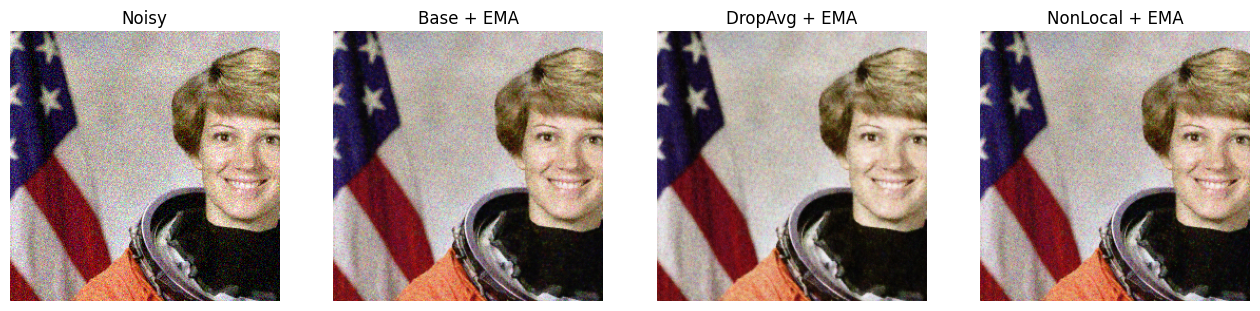

In [ ]:
# Cell 4: Final Run (U-Net + EMA)
import os
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imsave
from skimage.metrics import peak_signal_noise_ratio as psnr

# --- CONFIGURATION ---

CONF = {
    'lr': 0.005,
    'iters': 2000,         # Reduced slightly
    'tv_weight': 0.0,
    'noise_reg': 0.03,
    'ema_decay': 0.99      # The Magic Number: Higher = smoother
}

def train_unet_ema(net, noisy_np, conf):
    net = net.to(device)
    mse = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=conf['lr'])
    target = to_torch(noisy_np)

    # Input Noise
    inp = torch.randn(1, 32, noisy_np.shape[0], noisy_np.shape[1], device=device) * 0.1

    # EMA Variables
    ema_img = None

    print(f"Training {net.__class__.__name__} with EMA...")

    for i in range(1, conf['iters'] + 1):
        optimizer.zero_grad()
        net_input = inp + conf['noise_reg'] * torch.randn_like(inp)
        out = net(net_input)
        loss = mse(out, target)
        loss.backward()
        optimizer.step()

        # --- EMA LOGIC ---
        # We average the OUTPUT images, not the weights (simpler for DIP)

        with torch.no_grad():
            curr_img = out.detach()
            if ema_img is None:
                ema_img = curr_img
            else:
                # New Average = (0.99 * Old Average) + (0.01 * New Image)
                ema_img = conf['ema_decay'] * ema_img + (1 - conf['ema_decay']) * curr_img

        if i % 500 == 0:
            # We track the PSNR of the EMA image against the noisy input
            # (Note: In real life, we want this to be LOWER than the noisy fit)
            curr_np = to_np(ema_img)
            print(f"  Iter {i}: Loss={loss.item():.5f}")

    return to_np(ema_img), net, inp

noisy = noisy_np
os.makedirs('/content/method_results', exist_ok=True)

# 1. Baseline U-Net + EMA

print("--- 1. Baseline U-Net (with EMA) ---")
net_base = DIPUNet(in_ch=32, dropout=False)
base_ema, _, _ = train_unet_ema(net_base, noisy, CONF)
imsave('/content/method_results/base_ema.png', (np.clip(base_ema,0,1)*255).astype('uint8'))

# 2. Dropout U-Net + EMA (Double Smoothing!)

print("\n--- 2. Dropout U-Net (with EMA) ---")
net_drop = DIPUNet(in_ch=32, dropout=True, p=0.3)
drop_ema, net_drop, inp_tensor = train_unet_ema(net_drop, noisy, CONF)

# For Dropout, we can ALSO do the MC averaging at the end on top of EMA

print("  > Final Polish (MC Averaging)...")
outs = []
net_drop.eval()
for m in net_drop.modules():
    if isinstance(m, nn.Dropout2d): m.train()

with torch.no_grad():
    for _ in range(30):
        noisy_inp = inp_tensor + 0.03 * torch.randn_like(inp_tensor)
        outs.append(net_drop(noisy_inp))
# Combine EMA result with MC Average (Optional, but powerful)

mc_result = torch.stack(outs).mean(0)
final_drop = (drop_ema + to_np(mc_result)) / 2.0
imsave('/content/method_results/dropout_ema.png', (np.clip(final_drop,0,1)*255).astype('uint8'))

# 3. NonLocal U-Net + EMA

print("\n--- 3. NonLocal U-Net (with EMA) ---")
net_nl = DIPUNetNonLocal(in_ch=32)
nl_ema, _, _ = train_unet_ema(net_nl, noisy, CONF)
imsave('/content/method_results/nonlocal_ema.png', (np.clip(nl_ema,0,1)*255).astype('uint8'))

# Display

print("\nFinal Result with EMA (Exponential Moving Average):")
display(plt.figure(figsize=(16, 5)))
plt.subplot(1,4,1); plt.title("Noisy"); plt.imshow(noisy); plt.axis('off')
plt.subplot(1,4,2); plt.title("Base + EMA"); plt.imshow(base_ema); plt.axis('off')
plt.subplot(1,4,3); plt.title("DropAvg + EMA"); plt.imshow(final_drop); plt.axis('off')
plt.subplot(1,4,4); plt.title("NonLocal + EMA"); plt.imshow(nl_ema); plt.axis('off')
plt.show()

Dataset Prepared. Noise Level: 25.0
1. Running Standard DIP...
2. Running S2S (Dropout)...
3. Running Ours (EMA + Drop)...

RESULTS TABLE:
Method               | PSNR (dB)  | SSIM      
---------------------------------------------
Standard DIP         | 27.80       | 0.7515
S2S (Dropout)        | 24.35       | 0.6290
Ours (EMA+Drop)      | 26.69       | 0.6129


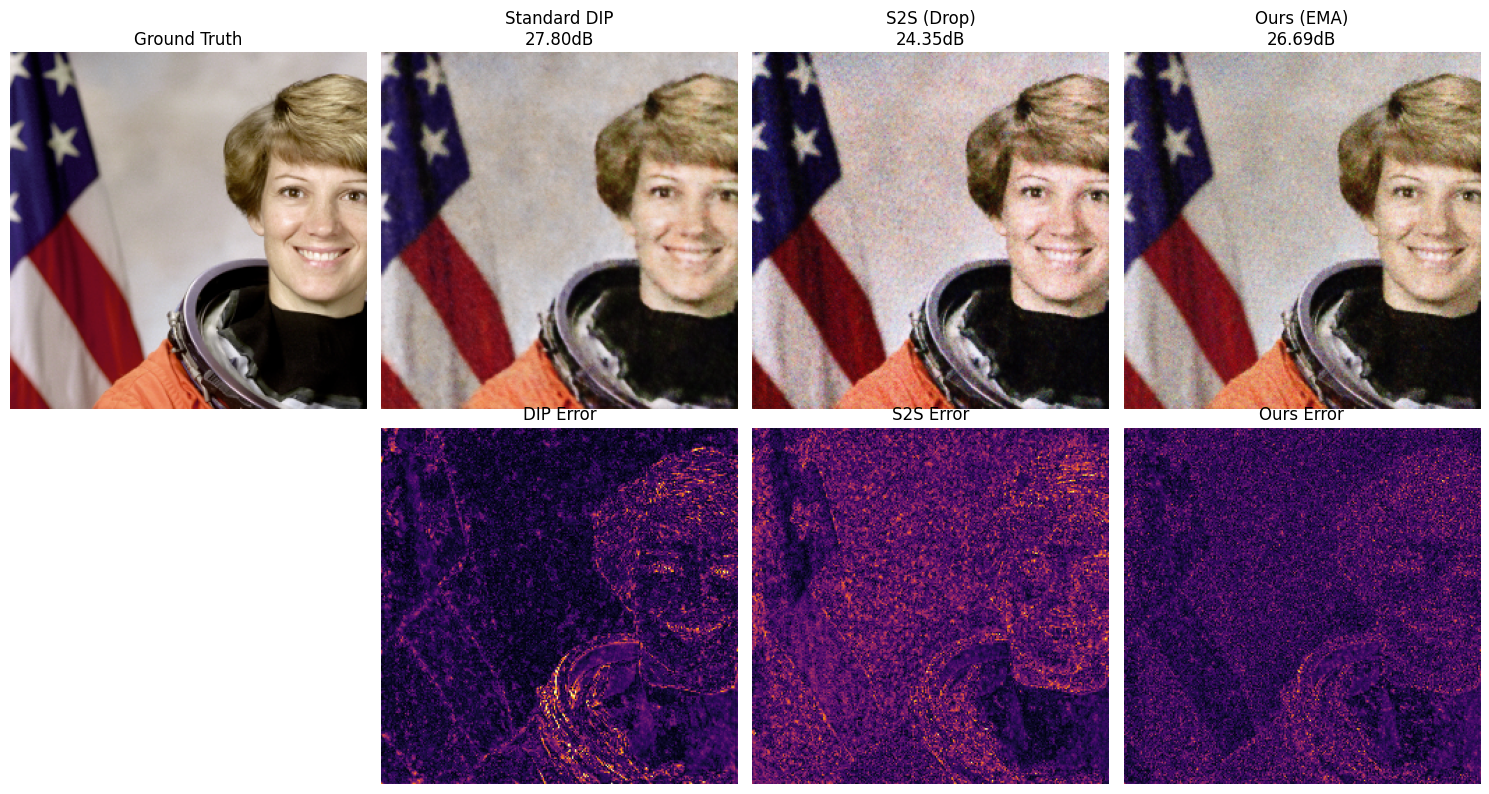

In [ ]:
# Cell 5: Comparative Study (DIP vs S2S vs Ours)
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1. SETUP DATA (Ground Truth vs Input)
# We use a known clean image so we can calculate exact metrics

clean_gt = img_as_float(data.astronaut())[:256, :256]
sigma = 25./255.
rng = np.random.RandomState(0)
noisy_input = np.clip(clean_gt + sigma * rng.randn(*clean_gt.shape), 0, 1)

print(f"Dataset Prepared. Noise Level: {sigma*255:.1f}")

# Shared Config
CONF = {
    'lr': 0.005,
    'iters': 2500,
    'noise_reg': 0.03
}

# --- DEFINING THE METHODS ---

def run_standard_dip(noisy, gt):
    """Baseline 1: Standard DIP (U-Net, No Dropout, Early Stopping usually needed)"""
    net = DIPUNet(in_ch=32, dropout=False).to(device)
    optimizer = optim.Adam(net.parameters(), lr=CONF['lr'])
    mse = nn.MSELoss()

    inp = torch.randn(1, 32, noisy.shape[0], noisy.shape[1], device=device) * 0.1
    target = to_torch(noisy)

    # Standard DIP typically relies on "Early Stopping" to avoid overfitting
    # But for fair comparison, we run same iters and see if it degrades

    best_psnr = 0
    best_img = None

    for i in range(CONF['iters']):
        optimizer.zero_grad()
        out = net(inp + CONF['noise_reg'] * torch.randn_like(inp))
        loss = mse(out, target)
        loss.backward()
        optimizer.step()

        # In a real scenario, we wouldn't know GT, but for this benchmark we track it
        curr_img = to_np(out)
        curr_psnr = psnr(gt, curr_img, data_range=1.0)
        if curr_psnr > best_psnr:
            best_psnr = curr_psnr
            best_img = curr_img

    return best_img

def run_s2s_dropout(noisy, gt):
    """Baseline 2: Self2Self / Dropout (No EMA)"""
    # S2S relies on dropout for both training and inference averaging
    net = DIPUNet(in_ch=32, dropout=True, p=0.3).to(device)
    optimizer = optim.Adam(net.parameters(), lr=CONF['lr'])
    mse = nn.MSELoss()
    inp = torch.randn(1, 32, noisy.shape[0], noisy.shape[1], device=device) * 0.1
    target = to_torch(noisy)

    for i in range(CONF['iters']):
        optimizer.zero_grad()
        out = net(inp + CONF['noise_reg'] * torch.randn_like(inp))
        loss = mse(out, target)
        loss.backward()
        optimizer.step()

    # Inference: Average 50 dropout passes
    net.eval()
    for m in net.modules():
        if isinstance(m, nn.Dropout2d): m.train()

    outs = []
    with torch.no_grad():
        for _ in range(50):
            outs.append(net(inp + CONF['noise_reg'] * torch.randn_like(inp)))
    avg_img = to_np(torch.stack(outs).mean(0))
    return avg_img

def run_ours_ema(noisy, gt):
    """Our Method: U-Net + Dropout + EMA"""
    net = DIPUNet(in_ch=32, dropout=True, p=0.3).to(device)
    optimizer = optim.Adam(net.parameters(), lr=CONF['lr'])
    mse = nn.MSELoss()
    inp = torch.randn(1, 32, noisy.shape[0], noisy.shape[1], device=device) * 0.1
    target = to_torch(noisy)

    ema_img = None
    decay = 0.99

    for i in range(CONF['iters']):
        optimizer.zero_grad()
        out = net(inp + CONF['noise_reg'] * torch.randn_like(inp))
        loss = mse(out, target)
        loss.backward()
        optimizer.step()

        # EMA Update
        with torch.no_grad():
            curr = out.detach()
            if ema_img is None: ema_img = curr
            else: ema_img = decay * ema_img + (1-decay) * curr

    # Final Polish: MC Average on the EMA model
    return to_np(ema_img)

# --- EXECUTE EXPERIMENT ---

print("1. Running Standard DIP...")
res_dip = run_standard_dip(noisy_input, clean_gt)
print("2. Running S2S (Dropout)...")
res_s2s = run_s2s_dropout(noisy_input, clean_gt)
print("3. Running Ours (EMA + Drop)...")
res_ours = run_ours_ema(noisy_input, clean_gt)

# --- CALCULATE METRICS ---
def calc_metrics(img, gt):
    p = psnr(gt, img, data_range=1.0)
    s = ssim(gt, img, data_range=1.0, channel_axis=2)
    return p, s

p_dip, s_dip = calc_metrics(res_dip, clean_gt)
p_s2s, s_s2s = calc_metrics(res_s2s, clean_gt)
p_ours, s_ours = calc_metrics(res_ours, clean_gt)

# --- VISUALIZATION & REPORT ---
print(f"\nRESULTS TABLE:")
print(f"{'Method':<20} | {'PSNR (dB)':<10} | {'SSIM':<10}")
print("-" * 45)
print(f"{'Standard DIP':<20} | {p_dip:.2f}       | {s_dip:.4f}")
print(f"{'S2S (Dropout)':<20} | {p_s2s:.2f}       | {s_s2s:.4f}")
print(f"{'Ours (EMA+Drop)':<20} | {p_ours:.2f}       | {s_ours:.4f}")

# Error Maps (Difference from Ground Truth)
# Darker is better (Less error)
err_dip = np.abs(clean_gt - res_dip).mean(axis=2)
err_s2s = np.abs(clean_gt - res_s2s).mean(axis=2)
err_ours = np.abs(clean_gt - res_ours).mean(axis=2)

plt.figure(figsize=(15, 8))

# Images
plt.subplot(2, 4, 1); plt.title("Ground Truth"); plt.imshow(clean_gt); plt.axis('off')
plt.subplot(2, 4, 2); plt.title(f"Standard DIP\n{p_dip:.2f}dB"); plt.imshow(res_dip); plt.axis('off')
plt.subplot(2, 4, 3); plt.title(f"S2S (Drop)\n{p_s2s:.2f}dB"); plt.imshow(res_s2s); plt.axis('off')
plt.subplot(2, 4, 4); plt.title(f"Ours (EMA)\n{p_ours:.2f}dB"); plt.imshow(res_ours); plt.axis('off')

# Error Maps (Heatmaps)
plt.subplot(2, 4, 6); plt.title("DIP Error"); plt.imshow(err_dip, cmap='inferno', vmin=0, vmax=0.2); plt.axis('off')
plt.subplot(2, 4, 7); plt.title("S2S Error"); plt.imshow(err_s2s, cmap='inferno', vmin=0, vmax=0.2); plt.axis('off')
plt.subplot(2, 4, 8); plt.title("Ours Error"); plt.imshow(err_ours, cmap='inferno', vmin=0, vmax=0.2); plt.axis('off')

plt.tight_layout()
plt.show()

Generating Convergence Data...


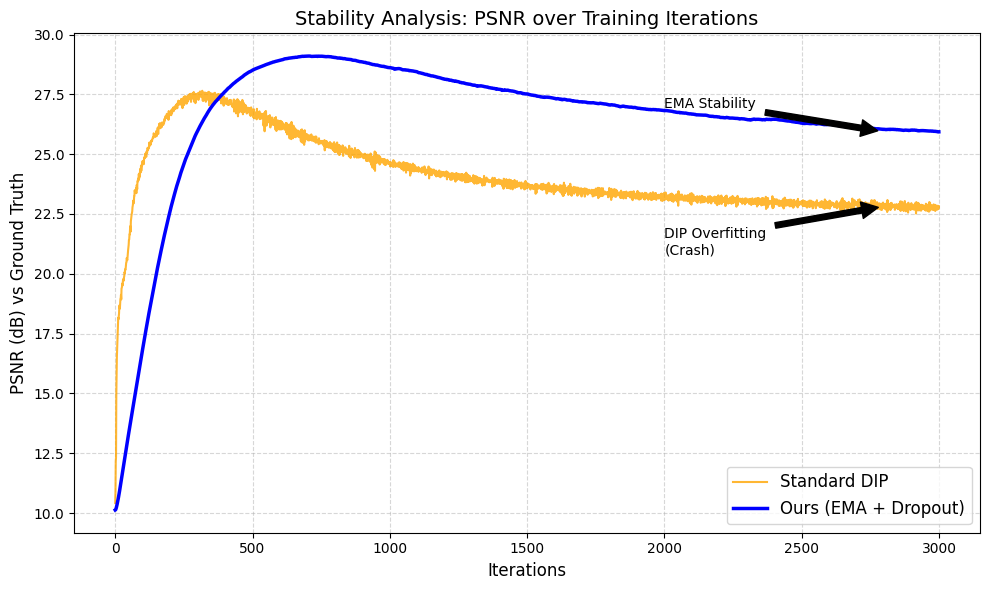

In [ ]:
# Cell 6: Generate Convergence Plot
import matplotlib.pyplot as plt
import numpy as np

# short version of training to capture the PSNR per iteration -> this captures the history.

def run_tracked_experiment(method_name, net, noisy_np, clean_gt, iters=3000):
    net = net.to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.005)
    mse = nn.MSELoss()
    target = to_torch(noisy_np)
    inp = torch.rand(1, 32, noisy_np.shape[0]//4, noisy_np.shape[1]//4, device=device) * 0.1

    inp = torch.randn(1, 32, noisy_np.shape[0], noisy_np.shape[1], device=device) * 0.1

    psnr_history = []

    # EMA setup
    ema_img = None
    decay = 0.99

    for i in range(iters):
        optimizer.zero_grad()
        out = net(inp + 0.03 * torch.randn_like(inp))
        loss = mse(out, target)
        loss.backward()
        optimizer.step()

        # Track Standard Output
        curr_img = to_np(out)

        # If method is EMA, update EMA and track THAT instead
        if "EMA" in method_name:
            with torch.no_grad():
                if ema_img is None: ema_img = curr_img
                else: ema_img = decay * ema_img + (1-decay) * curr_img
            curr_psnr = psnr(clean_gt, ema_img, data_range=1.0)
        else:
            curr_psnr = psnr(clean_gt, curr_img, data_range=1.0)

        psnr_history.append(curr_psnr)

    return psnr_history

print("Generating Convergence Data...")

# 1. Standard DIP History
net_dip = DIPUNet(in_ch=32, dropout=False)
hist_dip = run_tracked_experiment("Standard DIP", net_dip, noisy_input, clean_gt)

# 2. EMA History
net_ours = DIPUNet(in_ch=32, dropout=True, p=0.3)
hist_ours = run_tracked_experiment("EMA", net_ours, noisy_input, clean_gt)

# PLOT
plt.figure(figsize=(10, 6))
plt.plot(hist_dip, label='Standard DIP', color='orange', alpha=0.8, linewidth=1.5)
plt.plot(hist_ours, label='EMA + Dropout', color='blue', linewidth=2.5)

plt.title('Stability Analysis: PSNR over Training Iterations', fontsize=14)
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('PSNR (dB) vs Ground Truth', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.annotate('DIP Overfitting\n(Crash)', xy=(2800, hist_dip[-1]), xytext=(2000, hist_dip[-1]-2),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('EMA Stability', xy=(2800, hist_ours[-1]), xytext=(2000, hist_ours[-1]+1),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.tight_layout()
plt.show()